# Data Exploration Notebook

In [1]:
import io, os
import pandas as pd

## Connect to S3 Data Source

Use the Domino Data Source snippets in the left hand of the workspace page to connect to the datasource by pasting below and executing the cell

In [2]:
######################################################
#### Replace With Python Snippet From Data Source ####
######################################################
from domino.data_sources import DataSourceClient

# instantiate a client and fetch the datasource instance
object_store = DataSourceClient().get_datasource("credit_card_fraud_detection")

# list objects available in the datasource
objects = object_store.list_objects()

## get content as binary
# content = object_store.get("key")

## download content to file
# object_store.download_file("key", "./path/to/local/file")

## Download content to file object
# f = io.BytesIO()
# object_store.download_fileobj("key", f)

## Load CSV Data to Pandas Dataframe

In [3]:
raw_filename = 'raw_cc_transactions.csv'
clean_filename = 'clean_cc_transactions.csv'
datasource_name = 'credit_card_fraud_detection'
domino_working_dir = os.environ.get("DOMINO_WORKING_DIR", ".")
domino_project_name = os.environ.get("DOMINO_PROJECT_NAME", "my-local-project")

domino_datasource_dir = domino_working_dir.replace('code', 'data')
domino_dataset_dir = f"{domino_datasource_dir}/{domino_project_name}"
domino_artifact_dir = domino_working_dir.replace('code', 'artifacts')

ds = DataSourceClient().get_datasource(datasource_name)
buf = io.BytesIO()
ds.download_fileobj(raw_filename, buf)
buf.seek(0)
raw_df = pd.read_csv(buf)
print(f"Loaded {len(raw_df):,} rows from {raw_filename}")

Loaded 78,324 rows from raw_cc_transactions.csv


## Remove Dirty Data

In [4]:
clean_df = raw_df.dropna()
rows_removed = len(raw_df) - len(clean_df)
pct_removed = 100 * rows_removed / len(raw_df)

print(f"🧹 Dropped {rows_removed:,} rows with missing data ({pct_removed:.2f}%)")
clean_df.head()

🧹 Dropped 1,114 rows with missing data (1.42%)


,Time,Amount,Age,Tenure,MerchantRisk,DeviceTrust,Txn24h,Avg30d,IPReputation,Latitude,Longitude,DistFromHome,Hour,TxType,DeviceType,MerchantCat,Channel,CardPresent,Class
0,3,18.038451,45.751591,7,1.557254,1.322673,1.0,-0.426200,-3.218532,40.596925,-102.693668,-1.301393,0,transfer,mobile,electronics,in-store,1,0
1,3,58.226572,44.510153,6,0.286148,-0.533274,1.0,-0.192640,0.030137,37.858083,-110.551127,-1.495352,0,transfer,mobile,gas,contactless,1,0
2,4,56.560553,37.542407,11,1.126922,-0.568457,0.0,-2.376663,1.002909,39.746631,-67.000000,3.343419,0,purchase,desktop,electronics,online,0,1
3,4,59.420173,36.014418,22,1.540312,0.377283,1.0,-1.915332,0.567673,40.126965,-67.000000,2.727808,0,purchase,desktop,travel,contactless,1,0
4,6,16.115871,34.819242,0,-1.961402,-0.542454,2.0,1.446642,1.104059,41.285167,-67.000000,1.589769,0,purchase,mobile,grocery,chip,0,1


### Generate Plots & Charts

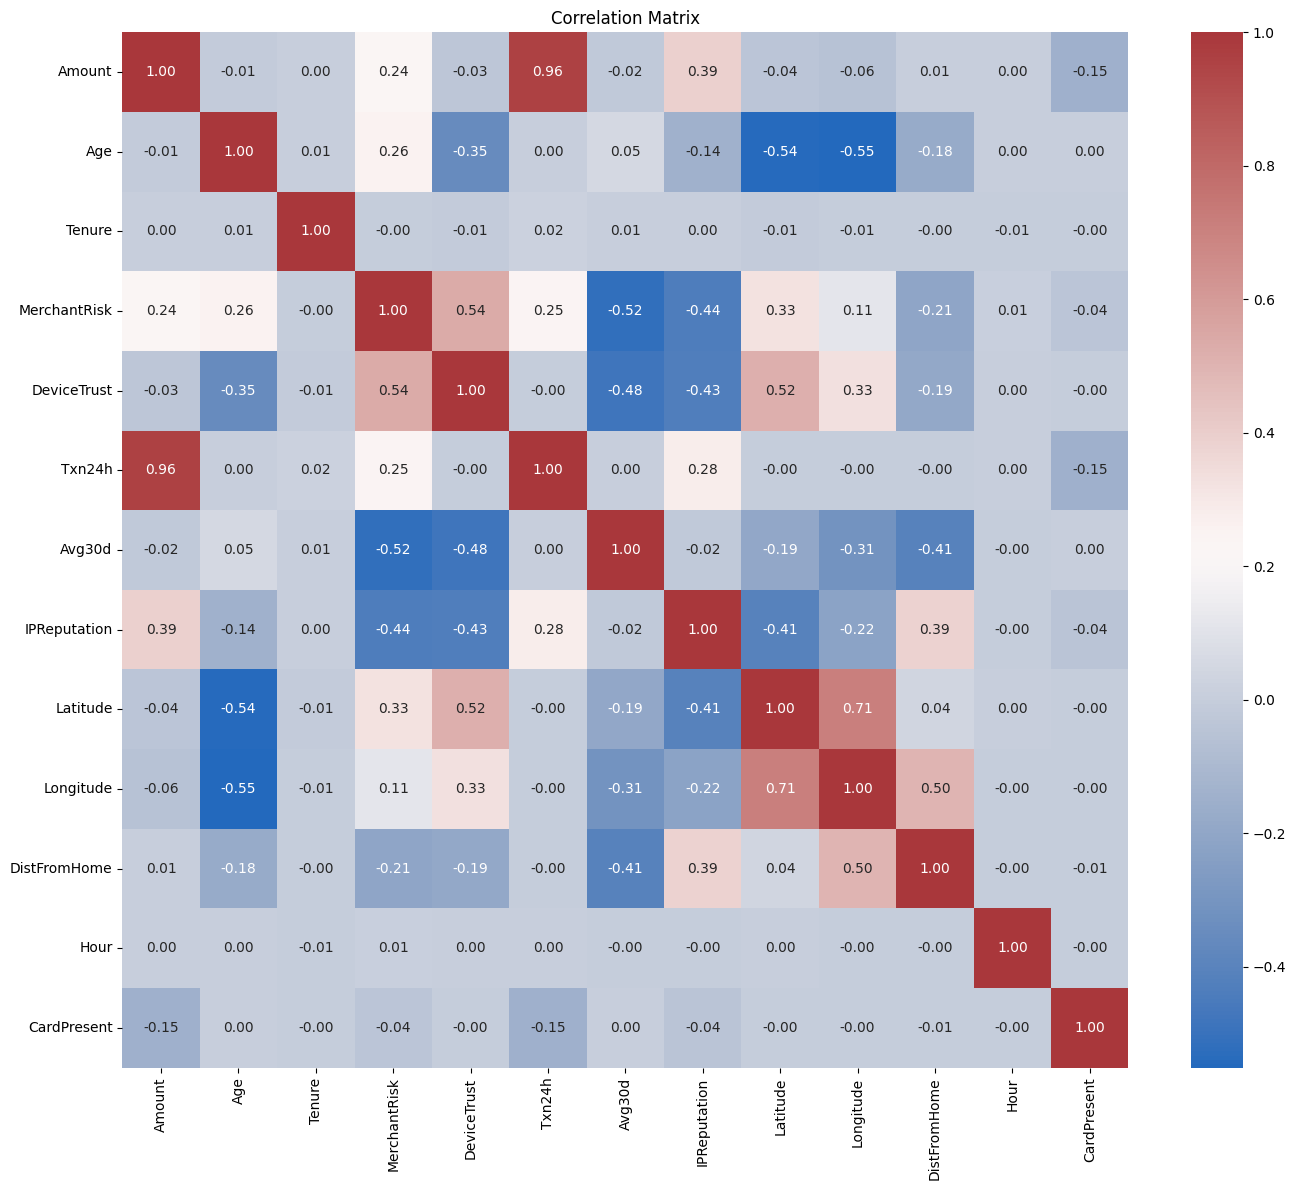

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from ydata_profiling import ProfileReport

num_df = clean_df.select_dtypes(include="number").drop(columns=["Time", "Class"], errors="ignore")

# Correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation Matrix")
plt.tight_layout()

corr_path = str(f"{domino_artifact_dir}/raw_correlation_matrix.png")
plt.savefig(corr_path, dpi=300, bbox_inches='tight')
plt.show()

# HTML Exploritory Data Analysis (EDA) Report
#profile = ProfileReport(
#    clean_df, 
#    title="Credit Card Fraud Detection - EDA Report",
#    explorative=True,
#    minimal=True
#)
#
#eda_path = str(f"{domino_artifact_dir}/preprocessing_report.html")
#profile.to_file(eda_path)
#profile.to_notebook_iframe()
#


### Fraud Correlation Plots

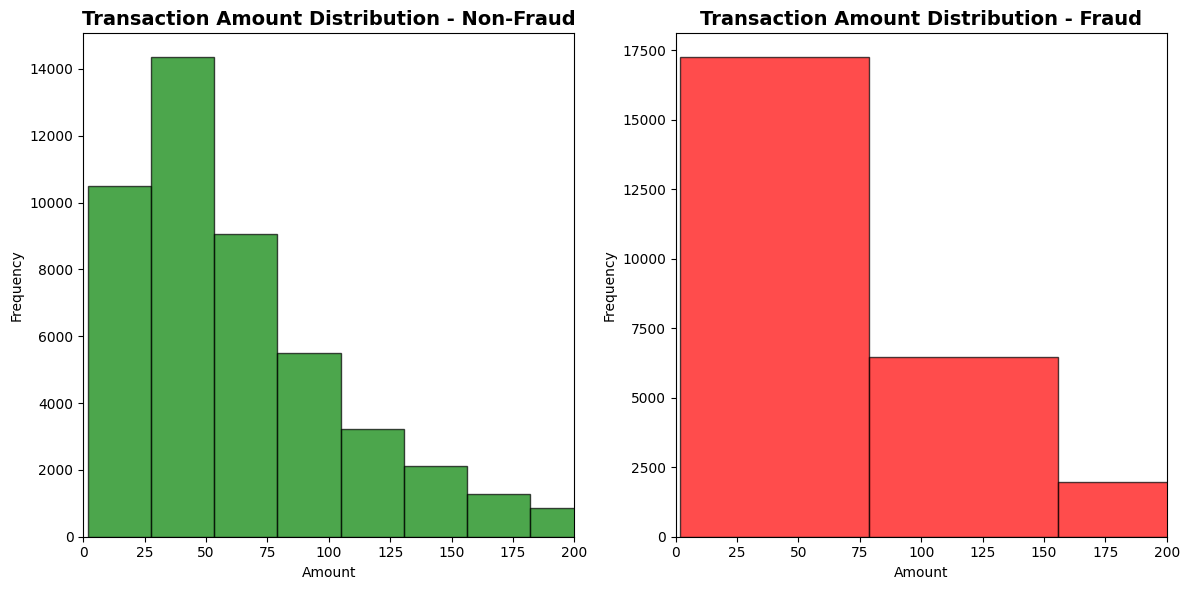

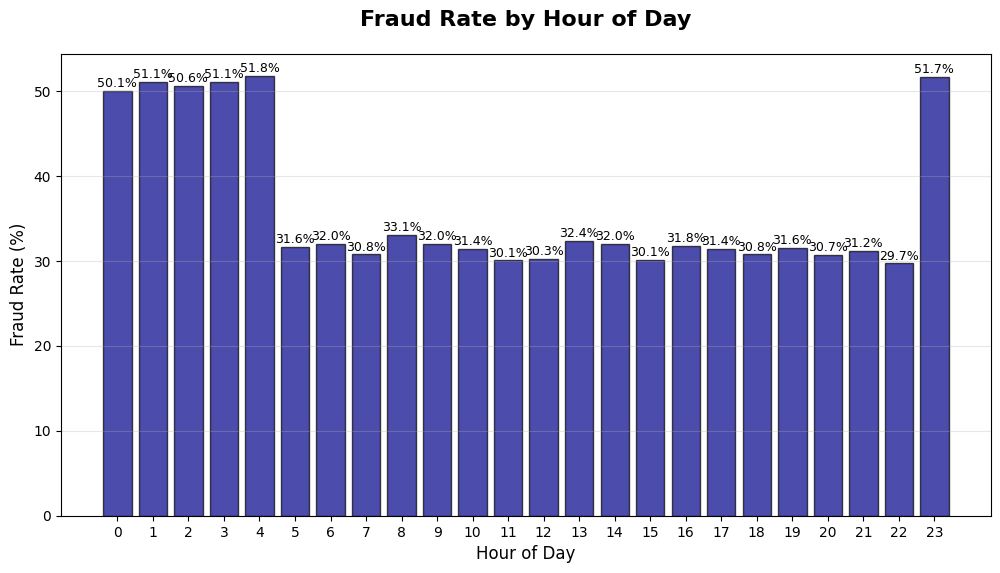

Peak fraud hour: 4:00 with 51.82% fraud rate
Lowest fraud hour: 22:00 with 29.72% fraud rate


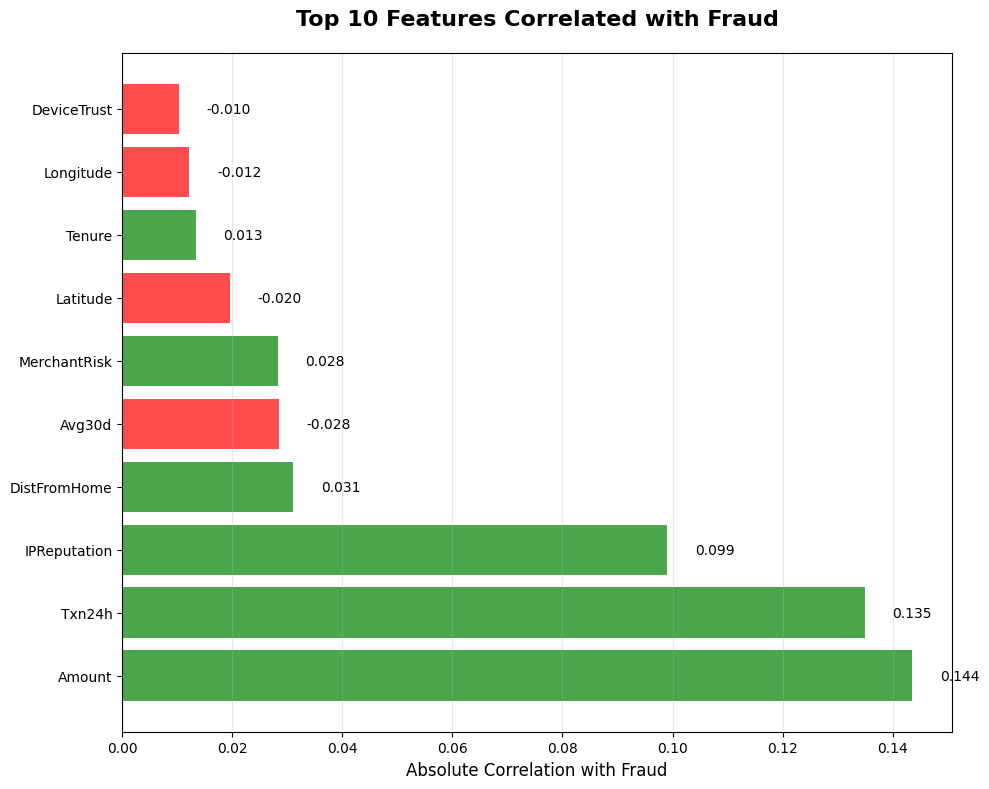

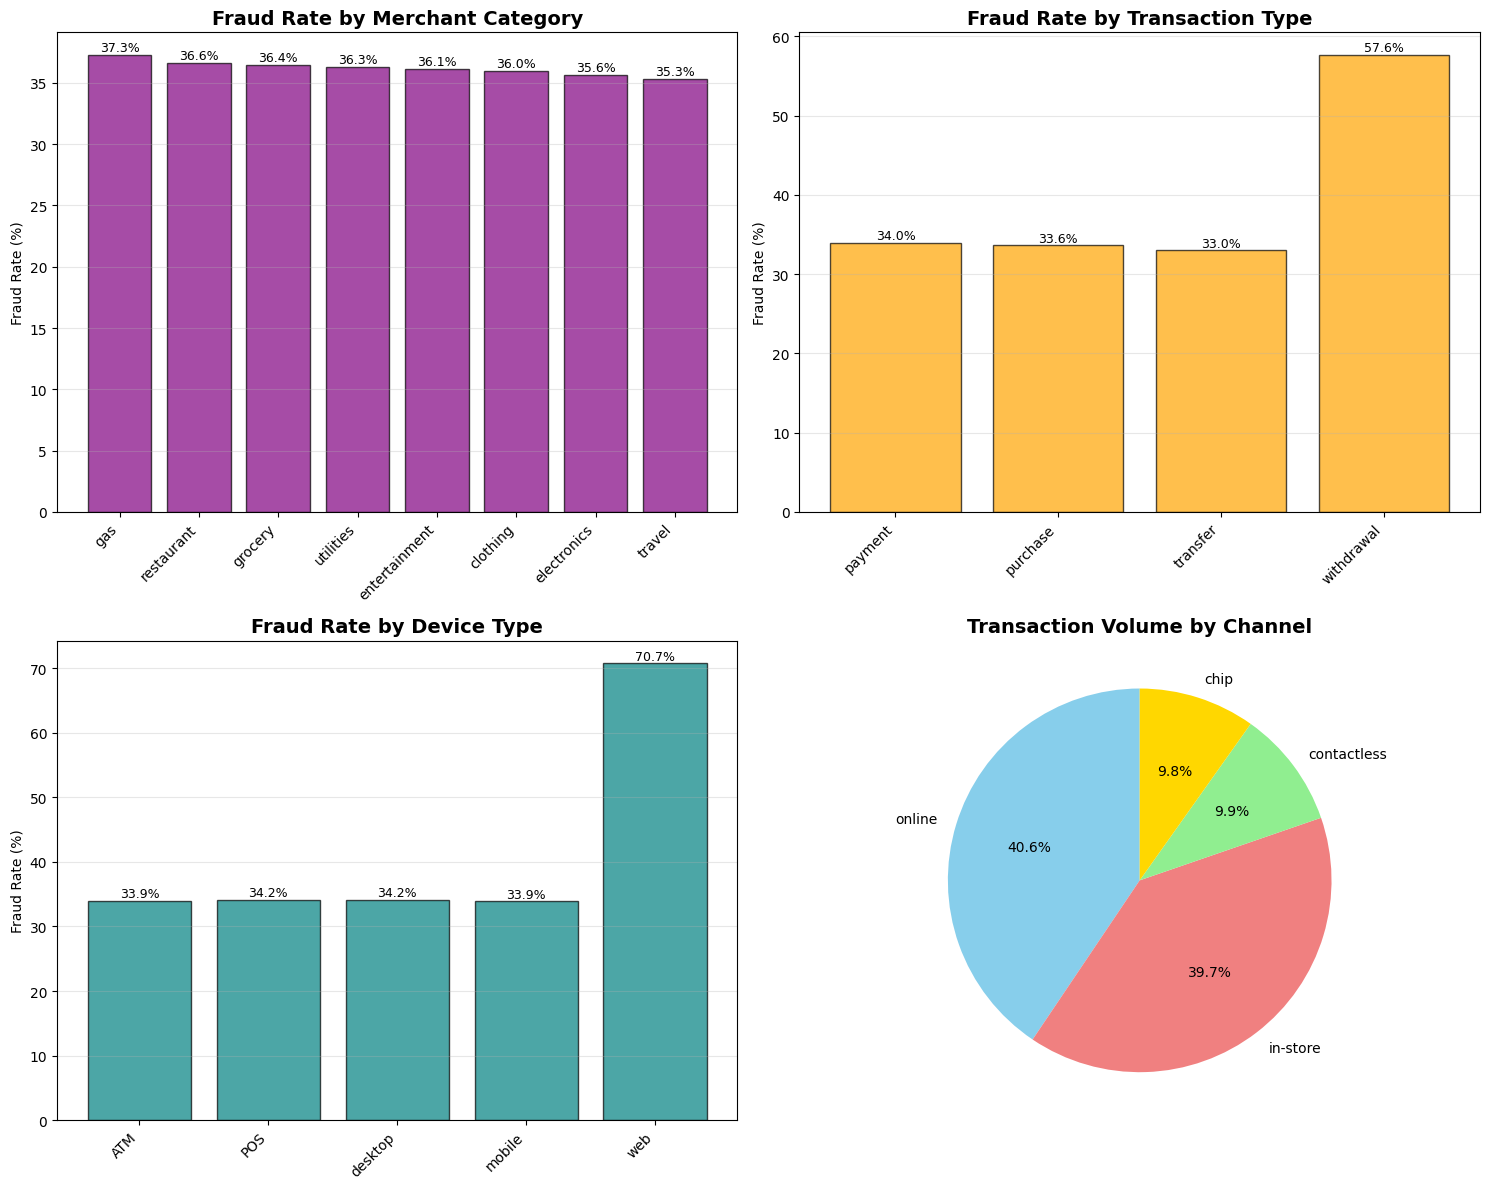


=== Fraud Analysis Summary ===

Highest fraud merchant category: gas (37.26%)
Highest fraud transaction type: withdrawal (57.63%)
Highest fraud device type: web (70.74%)


In [6]:
###### Transaction Amount Distribution by Class (Fraud vs Non-Fraud) #####
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
clean_df[clean_df['Class'] == 0]['Amount'].plot(kind='hist', bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Transaction Amount Distribution - Non-Fraud', fontsize=14, fontweight='bold')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xlim(0, 200)  # Limiting for better visualization

plt.subplot(1, 2, 2)
clean_df[clean_df['Class'] == 1]['Amount'].plot(kind='hist', bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Transaction Amount Distribution - Fraud', fontsize=14, fontweight='bold')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xlim(0, 200)  # Limiting for better visualization

plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/amount_distribution_by_class.png", dpi=300, bbox_inches='tight')
plt.show()


##### Fraud Rate by Hour of Day #####
fraud_by_hour = clean_df.groupby('Hour')['Class'].agg(['mean', 'count'])
fraud_by_hour['fraud_rate_pct'] = fraud_by_hour['mean'] * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(fraud_by_hour.index, fraud_by_hour['fraud_rate_pct'], 
                color='darkblue', alpha=0.7, edgecolor='black')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.title('Fraud Rate by Hour of Day', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(0, 24))
plt.savefig(f"{domino_artifact_dir}/fraud_rate_by_hour.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"Peak fraud hour: {fraud_by_hour['fraud_rate_pct'].idxmax()}:00 with {fraud_by_hour['fraud_rate_pct'].max():.2f}% fraud rate")
print(f"Lowest fraud hour: {fraud_by_hour['fraud_rate_pct'].idxmin()}:00 with {fraud_by_hour['fraud_rate_pct'].min():.2f}% fraud rate")



##### Top 10 Features Correlation with Fraud #####
numeric_cols = ['Amount', 'Age', 'Tenure', 'MerchantRisk', 'DeviceTrust', 
                'Txn24h', 'Avg30d', 'IPReputation', 'Latitude', 'Longitude', 
                'DistFromHome']
correlations = clean_df[numeric_cols + ['Class']].corr()['Class'].drop('Class')
top_correlations = correlations.abs().sort_values(ascending=False).head(10)

# Create horizontal bar plot
plt.figure(figsize=(10, 8))
colors = ['red' if corr < 0 else 'green' for corr in correlations[top_correlations.index]]
bars = plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)

# Add value labels
for i, (idx, val) in enumerate(top_correlations.items()):
    actual_corr = correlations[idx]
    plt.text(val + 0.005, i, f'{actual_corr:.3f}', va='center')

plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Absolute Correlation with Fraud', fontsize=12)
plt.title('Top 10 Features Correlated with Fraud', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/top_features_correlation.png", dpi=300, bbox_inches='tight')
plt.show()

##### Fraud Analysis by Merchant Category and Transaction Type #####
# Create a figure with subplots for categorical analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Fraud rate by Merchant Category
ax1 = axes[0, 0]
fraud_by_merchant = clean_df.groupby('MerchantCat')['Class'].agg(['mean', 'count'])
fraud_by_merchant['fraud_rate_pct'] = fraud_by_merchant['mean'] * 100
fraud_by_merchant = fraud_by_merchant.sort_values('fraud_rate_pct', ascending=False)

bars1 = ax1.bar(range(len(fraud_by_merchant)), fraud_by_merchant['fraud_rate_pct'], 
                 color='purple', alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(fraud_by_merchant)))
ax1.set_xticklabels(fraud_by_merchant.index, rotation=45, ha='right')
ax1.set_title('Fraud Rate by Merchant Category', fontsize=14, fontweight='bold')
ax1.set_ylabel('Fraud Rate (%)')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Fraud rate by Transaction Type
ax2 = axes[0, 1]
fraud_by_type = clean_df.groupby('TxType')['Class'].agg(['mean', 'count'])
fraud_by_type['fraud_rate_pct'] = fraud_by_type['mean'] * 100

bars2 = ax2.bar(range(len(fraud_by_type)), fraud_by_type['fraud_rate_pct'], 
                color='orange', alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(fraud_by_type)))
ax2.set_xticklabels(fraud_by_type.index, rotation=45, ha='right')
ax2.set_title('Fraud Rate by Transaction Type', fontsize=14, fontweight='bold')
ax2.set_ylabel('Fraud Rate (%)')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Fraud rate by Device Type
ax3 = axes[1, 0]
fraud_by_device = clean_df.groupby('DeviceType')['Class'].agg(['mean', 'count'])
fraud_by_device['fraud_rate_pct'] = fraud_by_device['mean'] * 100

bars3 = ax3.bar(range(len(fraud_by_device)), fraud_by_device['fraud_rate_pct'], 
                color='teal', alpha=0.7, edgecolor='black')
ax3.set_xticks(range(len(fraud_by_device)))
ax3.set_xticklabels(fraud_by_device.index, rotation=45, ha='right')
ax3.set_title('Fraud Rate by Device Type', fontsize=14, fontweight='bold')
ax3.set_ylabel('Fraud Rate (%)')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 4. Transaction volume by channel
ax4 = axes[1, 1]
channel_counts = clean_df['Channel'].value_counts()
colors_pie = ['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(channel_counts)]
wedges, texts, autotexts = ax4.pie(channel_counts.values, labels=channel_counts.index, 
                                    autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax4.set_title('Transaction Volume by Channel', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/categorical_fraud_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Fraud Analysis Summary ===")
print(f"\nHighest fraud merchant category: {fraud_by_merchant.index[0]} ({fraud_by_merchant['fraud_rate_pct'].iloc[0]:.2f}%)")
print(f"Highest fraud transaction type: {fraud_by_type['fraud_rate_pct'].idxmax()} ({fraud_by_type['fraud_rate_pct'].max():.2f}%)")
print(f"Highest fraud device type: {fraud_by_device['fraud_rate_pct'].idxmax()} ({fraud_by_device['fraud_rate_pct'].max():.2f}%)")


In [7]:
print(f"Generated and saved plots and report")

Generated and saved plots and report


### Save Dataframe to Domino Dataset 

In [8]:
clean_df.to_csv(f"{domino_dataset_dir}/{clean_filename}")
print(f"Check to see that your dataset has been recently updated at {domino_dataset_dir}/{clean_filename}")

Check to see that your dataset has been recently updated at /mnt/data/Fraud-Detection-Workshop/clean_cc_transactions.csv
